# Librerías

In [17]:
# Librerias
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
import matplotlib.dates as mdates
from tensorflow import keras
from tensorflow.keras import layers
from statsmodels.tsa.seasonal import seasonal_decompose
from tensorflow.keras.utils import timeseries_dataset_from_array
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.layers import Conv1D, LSTM, Dense
from statsmodels.tsa.stattools import adfuller
from keras.regularizers import l1_l2
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
import math
from sklearn.metrics import confusion_matrix
from sklearn.utils import class_weight
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report



# Carga de datos

In [18]:
# Se cargaarchivo CSV 
df = pd.read_csv('final_dataset.csv', parse_dates=['t'], index_col=['t']).drop(columns= ['Unnamed: 0', 'pc12'])
df.columns

Index(['symbol', 'o', 'h', 'l', 'c', 'v', 'n', 'vw', 'diff', 'emaS', 'emaM',
       'emaL', 'std', 'pc', 'mvS', 'mvL', 'mnS', 'mnL', 'rsi', 'rsid', 'rlmS',
       'rlmL', 'rlmD', 'obv', 'obvmS', 'obvmL', 'obvsL', 'obvSH', 'lavgv',
       'lavm', 'lavs', 'avgv', 'ewm_12', 'ewm_26', 'macd', 'signal',
       'macd_std', 'macds', 'financial_data_age', 'P/E', 'P/S', 'P/B',
       'EPS_Growth', 'ROE', 'ROA', 'Gross_Margin', 'Operating_Margin',
       'Net_Profit_Margin', 'Current_Ratio', 'Debt_to_Equity', 'FCF',
       'spy_value', 'time_embed_day_sin', 'time_embed_day_cos',
       'time_embed_week_sin', 'time_embed_week_cos', 'time_embed_month_sin',
       'time_embed_month_cos', 'time_embed_year_sin', 'time_embed_year_cos',
       'market_correlation', 'market_long_term_trend',
       'market_short_term_trend', 'market_change', 'alpha', 'beta'],
      dtype='object')

# Análisis descriptivo básico y transformaciones

In [19]:
# Revisar empresas
unique_symbols = df['symbol'].unique()
print(unique_symbols)

['BABA' 'AAPL' 'AMZN' 'META' 'MSFT' 'TSLA' 'BAC' 'GOOG' 'JPM' 'KO' 'PFE'
 'XOM' 'CVX' 'NVDA']


In [20]:
# Foco en una empresa paa hacer las pruebas (Microsoft en este caso)
data = df[df['symbol'] == 'MSFT' ].drop(columns= ['symbol', 'spy_value'])

Considerando una estrategia de inversión diaria, en este caso de probará con datos agregados a nivel diario.

In [21]:
# Crear diccionario para entregar la información de agregación de cada columna
agg_dict = {col: 'mean' for col in data.columns}

agg_dict['o'] = 'last'
agg_dict['c'] = 'last'
agg_dict['h'] = 'last'
agg_dict['l'] = 'last'

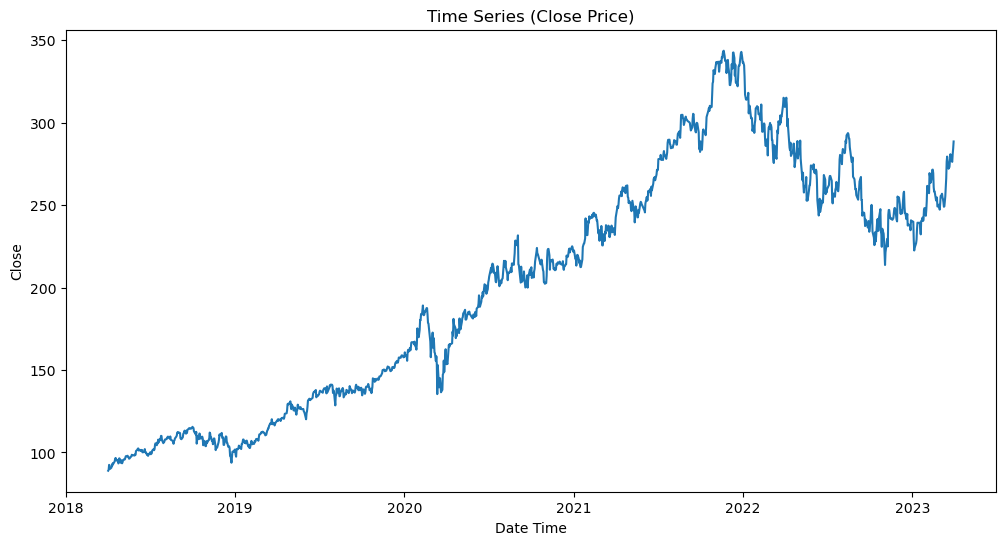

In [22]:
# Agregar a nivel diario y visualizar el close, que será la base para crear el target que despues se calculará como la diferencia % de close

df_daily = data.resample('D').agg(agg_dict)
df_daily = df_daily.dropna(how='all')

plt.figure(figsize=(12, 6))
plt.plot(df_daily['c'])
plt.xlabel('Date Time')
plt.ylabel('Close')
plt.title('Time Series (Close Price)')
plt.show()


Esta vez se crea una variable target que mide la suma de la variación % entre una dia cualquiera y el anterior + la variación % entre ese mismo dia y 5 días antes. Se elige 5 dado que para hacer la predicciones se usará times series con una ventana de 5 días de variables explicativas y un target del siguiente día. Es un modelo de clasificación

In [23]:
# Se crea el target 

df_daily['prev_close1'] = df_daily['c'].shift(1)
df_daily['prev_close5'] = df_daily['c'].shift(5)


df_daily['close_diff1'] = (df_daily['c'] - df_daily['prev_close1']) /  df_daily['prev_close1'] *100
df_daily['close_diff5'] = (df_daily['c'] - df_daily['prev_close5']) /  df_daily['prev_close5'] *100
df_daily['close_diff_15'] = ( df_daily['close_diff1'] + df_daily['close_diff5']) 


df_daily.drop(columns=['prev_close1'], inplace=True)
df_daily.drop(columns=['prev_close5'], inplace=True)
df_daily.drop(columns=['close_diff1'], inplace=True)
df_daily.drop(columns=['close_diff5'], inplace=True)



In [24]:
# Se revisa lo creado
df_daily[['c', 'close_diff_15']][0:10]

,c,close_diff_15
t,,
2018-04-02,88.95,NaN
2018-04-03,89.44,NaN
2018-04-04,92.50,NaN
2018-04-05,90.80,NaN
2018-04-06,90.05,NaN
2018-04-09,90.80,2.912691
2018-04-10,92.70,5.737413
2018-04-11,92.05,-1.187673
2018-04-12,93.48,4.505045


(array([  1.,   2.,  12.,  91., 421., 661., 143.,  15.,   0.,   2.]),
 array([-27.56135987, -22.09604958, -16.6307393 , -11.16542901,
         -5.70011872,  -0.23480844,   5.23050185,  10.69581214,
         16.16112243,  21.62643271,  27.091743  ]),
 <BarContainer object of 10 artists>)

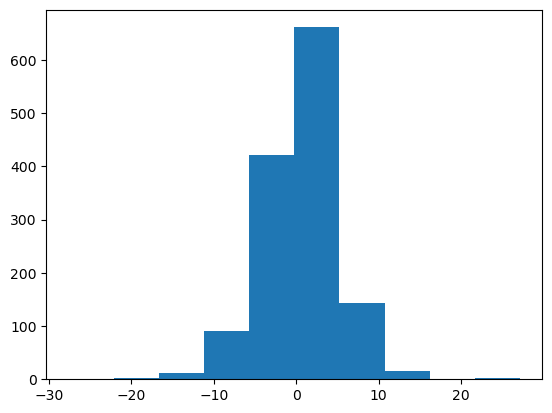

In [25]:
plt.hist(df_daily['close_diff_15'])

In [26]:
df_daily['close_diff_15'].std()

4.589749299699985

In [27]:
df_daily['close_diff_15'].mean()

0.5870149446196624

In [28]:
max(df_daily[ 'close_diff_15'])

nan

In [29]:
min(df_daily[ 'close_diff_15'])

nan

In [30]:
# Finalmente un umbral para clasificación. Interesa que el modelo pueda predecir los extremos low y hight (por cierto estos umbrales pueden cambiar)
low_threshold = -4  #refleja porcentaje de cambio
high_threshold = 4  #refleja porcentaje de cambio

#
def classify_change(change):
    if math.isnan(change):
        return change
    elif change < low_threshold:
        return 0 #'low'
    elif change > high_threshold:
        return 2 #'high'
    else:
        return 1 #'medium'

# Target final de clasificación
df_daily['close_diff_15%'] = df_daily['close_diff_15'].apply(classify_change)

In [31]:
# Revisión de datos creados
df_daily[['c', 'close_diff_15', 'close_diff_15%']][0:25]

,c,close_diff_15,close_diff_15%
t,,,
2018-04-02,88.95,NaN,NaN
2018-04-03,89.44,NaN,NaN
2018-04-04,92.50,NaN,NaN
2018-04-05,90.80,NaN,NaN
2018-04-06,90.05,NaN,NaN
2018-04-09,90.80,2.912691,1.0
2018-04-10,92.70,5.737413,2.0
2018-04-11,92.05,-1.187673,1.0
2018-04-12,93.48,4.505045,2.0


In [32]:
# Revisión de balance de clase. En caso de desbalance, lo cual se espera, se aplicarán pesos distintos en el modelo final consirando eñ objetivo de predecir mejor los extremos
value_counts = df_daily['close_diff_15%'].value_counts(dropna=False)

print(value_counts)


1.0    890
2.0    266
0.0    192
NaN      5
Name: close_diff_15%, dtype: int64


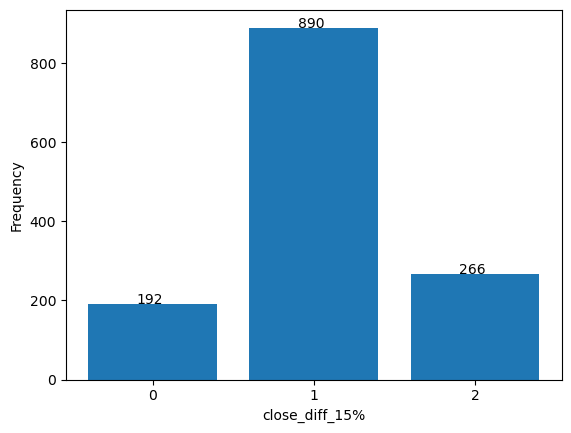

In [33]:
freq = df_daily['close_diff_15%'].value_counts()
x_values = freq.index
y_values = freq.values
plt.bar(x_values, y_values)
plt.xlabel('close_diff_15%')
plt.ylabel('Frequency')
plt.xticks([0, 1, 2])
for i, v in enumerate(y_values):
    plt.text(x_values[i] - 0.1, v + 0.1, str(v))
plt.show()

In [34]:
# Revisar y eliminar filas en blanco (dado que se sabe que son pocas)
blank_rows = df_daily[df_daily.isnull().any(axis=1)]
blank_rows

,o,h,l,c,v,n,vw,diff,emaS,emaM,...,time_embed_year_sin,time_embed_year_cos,market_correlation,market_long_term_trend,market_short_term_trend,market_change,alpha,beta,close_diff_15,close_diff_15%
t,,,,,,,,,,,,,,,,,,,,,
2018-04-02,88.65,88.95,88.65,88.95,3.239910e+06,23002.266667,89.352464,0.998331,0.998610,0.999613,...,0.999858,0.016544,0.684740,0.998461,0.998430,-0.026638,NaN,NaN,NaN,NaN
2018-04-03,89.54,89.59,89.41,89.44,2.304880e+06,15712.250000,89.227585,1.000464,1.000284,0.999744,...,0.999994,-0.000359,0.945665,0.999466,1.000270,0.365374,NaN,NaN,NaN,NaN
2018-04-04,92.46,92.55,92.33,92.50,2.218618e+06,14729.375000,90.003050,1.002070,1.001288,1.000061,...,0.999840,-0.017572,0.952216,0.999934,1.000612,0.283329,NaN,NaN,NaN,NaN
2018-04-05,91.56,91.56,90.63,90.80,1.851384e+06,12373.437500,92.374936,0.999031,1.000609,1.000544,...,0.999390,-0.034780,0.982104,1.000485,1.000599,-0.303835,NaN,NaN,NaN,NaN
2018-04-06,90.05,90.05,90.05,90.05,2.304907e+06,14730.625000,91.043825,0.999332,0.999035,1.000045,...,0.998643,-0.051978,0.978812,0.999979,0.999139,-0.174239,NaN,NaN,NaN,NaN


Eliminar filas en blancos (son pocas)

In [35]:
# Se eliminan filas sin datos
df_daily = df_daily.dropna() 

Para ayudar al modelo se convierten necesarias a estacionarias (luego del test adfuller)

In [36]:
def adf_test(timeseries):
    result = adfuller(timeseries)
    return result[1]  # Return the p-value

def test_columns(data,  target_column,threshold=0.05):
    non_stationary_columns = {}
    non_stationary_columns_justcolumns = []
    for column in data.columns:
        if column == target_column:  # Skip the target column
            continue
        p_value = adf_test(data[column])
        if p_value > threshold:
            non_stationary_columns[column] = p_value
            non_stationary_columns_justcolumns.append(column)

    return non_stationary_columns, non_stationary_columns_justcolumns



In [37]:
target_column = 'close_diff_15%'
non_stationary_columns = test_columns(df_daily, target_column)

In [38]:
# Se imprimen las no estacionarias
print("Non-stationary columns with p-value > 0.05:")
for column, p_value in non_stationary_columns[0].items():
    print(f"{column}: {p_value}")

Non-stationary columns with p-value > 0.05:
o: 0.7213204149682388
h: 0.7200294428939644
l: 0.7210079793420108
c: 0.7206885395113715
vw: 0.7167965802057471
mnS: 0.11849818785151334
mnL: 0.27213668282086034
rlmS: 0.07822259411925342
rlmL: 0.20411259683600075
obv: 0.9622809147095817
obvmS: 0.9658736157507037
obvmL: 0.9526520455047758
lavgv: 0.7463504220042523
lavm: 0.7112787354819785
ewm_12: 0.7122641777064055
ewm_26: 0.7052210405285227
macd_std: 0.1321328236092223
P/E: 0.10285988809909813
P/S: 0.7764950765254496
P/B: 0.7167965802057471
ROE: 0.12071056344770248
ROA: 0.31189747525800493
Operating_Margin: 0.19987427795264417
Net_Profit_Margin: 0.10390925360598463
Current_Ratio: 0.4690903636757203
Debt_to_Equity: 0.49382208156028085
FCF: 0.09527846362822634


In [39]:
df_daily = df_daily.copy()


In [40]:
# En base a resultado anterior, se hacen estacionarias estos atributos en base a la diferenciación con dia anterior
for column in non_stationary_columns[1]:
    df_daily[f'{column}_diff'] = df_daily[column].diff()

In [41]:
for column in non_stationary_columns[1]:
    df_daily.drop(column, axis=1, inplace=True)


In [42]:
# Se revisan columnas que van quedando
df_daily.columns

Index(['v', 'n', 'diff', 'emaS', 'emaM', 'emaL', 'std', 'pc', 'mvS', 'mvL',
       'rsi', 'rsid', 'rlmD', 'obvsL', 'obvSH', 'lavs', 'avgv', 'macd',
       'signal', 'macds', 'financial_data_age', 'EPS_Growth', 'Gross_Margin',
       'time_embed_day_sin', 'time_embed_day_cos', 'time_embed_week_sin',
       'time_embed_week_cos', 'time_embed_month_sin', 'time_embed_month_cos',
       'time_embed_year_sin', 'time_embed_year_cos', 'market_correlation',
       'market_long_term_trend', 'market_short_term_trend', 'market_change',
       'alpha', 'beta', 'close_diff_15', 'close_diff_15%', 'o_diff', 'h_diff',
       'l_diff', 'c_diff', 'vw_diff', 'mnS_diff', 'mnL_diff', 'rlmS_diff',
       'rlmL_diff', 'obv_diff', 'obvmS_diff', 'obvmL_diff', 'lavgv_diff',
       'lavm_diff', 'ewm_12_diff', 'ewm_26_diff', 'macd_std_diff', 'P/E_diff',
       'P/S_diff', 'P/B_diff', 'ROE_diff', 'ROA_diff', 'Operating_Margin_diff',
       'Net_Profit_Margin_diff', 'Current_Ratio_diff', 'Debt_to_Equity_diff',
     

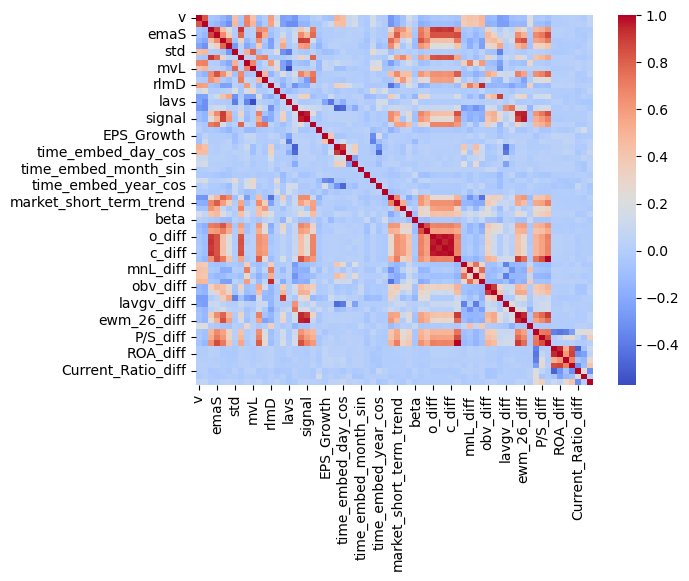

In [43]:
# Matriz correlacion (si bien se espera algunas correlaciones, si son pocas se probará directamente como esta el modelo)
corr_matrix = df_daily.corr()
sns.heatmap(corr_matrix, cmap='coolwarm')

plt.show()

In [44]:
# Se hace una copia del dataset y se eliminan los blancos si es que quedan
df_daily_final = df_daily.dropna() # .drop('c', axis=1)

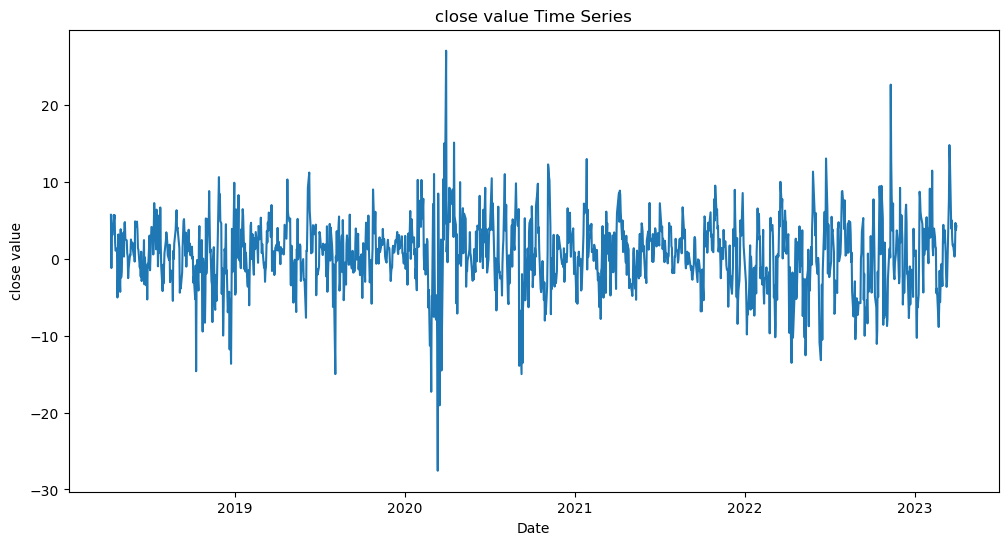

In [45]:
# Revisando la variable a partir de la cual se crea el target
timeseries2 = df_daily_final['close_diff_15']
column = 'close value'
#close_diff_15
plt.figure(figsize=(12, 6))
plt.plot(timeseries2)
#plt.plot(timeseries2)
plt.title(f'{column} Time Series')
plt.xlabel('Date')
plt.ylabel(column)
plt.show()

Estandarizar datos

Se estandarizan los datos para evitar dar mas peso a unos atributos que otros. 
Se aprovecha de dividir el dataset en X (65 variables explicativas) e y (target en modelo clasificación)

In [46]:
# Crear dataframe sin el target
df_without_target = df_daily_final.drop(columns=[target_column])

# Iniciar MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

# Ajustar escaler (numpy array)
df_scaled = scaler.fit_transform(df_without_target)

# Convertir este numpy array en dataframe por si fuese necesario posteriormente
df_scaled_df = pd.DataFrame(df_scaled, columns=df_without_target.columns, index=df_without_target.index)

# Agregar el target a este dataframe
df_scaled_df[target_column] = df_daily_final[target_column]

# Crear como nunpy array el target
targetcolumnarray = df_daily_final[target_column].values

# Convertir el dataset completo escalado a nunpy array por si fuese necesario posteriormente
df_scaled_df_array = df_scaled_df.values

# Mostrar target para probar
targetcolumnarray



array([2., 1., 2., ..., 2., 1., 2.])

In [47]:
targetcolumnarray.shape

(1347,)

In [48]:
df_scaled.shape

(1347, 65)

In [49]:
df_daily_final.shape

(1347, 66)

# Creación de dataset de Train y Validation

Como se dijo antes, se toman 5 días de datos de las 65 variables explicativas y como target se tiene el valor del siguiente día (low, medium o high variación de precio de cierre, antes calculado como "close_diff_15%")

In [50]:
# Se separan los datos en train y  validacion (70 y 30%)
num_train_samples = int(0.7 * len(df_daily_final))
num_val_samples =  len(df_daily_final) -num_train_samples #int(0.3 * len(df_daily_final))
print("Número de train_samples:", num_train_samples)
print("Número de val_samples:", num_val_samples)
#print("Número de test_samples:", num_test_samples)

Número de train_samples: 942
Número de val_samples: 405


In [51]:
# Check de donde queda el corte para validación
timestamp_at_num_train_samples = df_daily_final.index[num_train_samples]
timestamp_at_num_train_samples

Timestamp('2021-10-13 00:00:00')

In [52]:
# Se inicia lo necesario para crear las secuencias para el modelo. Iré con secuencias de 5 dias tomando todas las variables y el target será solo el close.
days_to_predict = 1
target_column_index = df_scaled_df.columns.get_loc('close_diff_15%') # Columna target
sampling_rate = 1 #Dado que los datos ya estan resumidos por día, se va tomando fila a fila sin saltos
sequence_length = 5 # 5 (5 días anteriores a tomar en cuenta).
delay = sampling_rate * (sequence_length ) #Comienzo del target
batch_size = 10 #La cantidad de batch que creará, cada una con X (samples) e y (target)


In [53]:
df_scaled[:-delay ].shape

(1342, 65)

In [54]:
targetcolumnarray[delay:].shape

(1342,)

In [55]:
# Se vuelve a revisar el balance de clase
unique_values, counts = np.unique(targetcolumnarray, return_counts=True)

for value, count in zip(unique_values, counts):
    print(f"{value}: {count}")


0.0: 192
1.0: 889
2.0: 266


In [56]:
# Finalmente se hace la separación

# Create datasets for the model
train_dataset = keras.utils.timeseries_dataset_from_array(
    df_scaled[:-delay ],
    targets=  targetcolumnarray[delay:], #   df_scaled[:, target_column_index][delay:] ,       #targets[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

val_dataset = keras.utils.timeseries_dataset_from_array(
    df_scaled[:-delay ],
    targets=  targetcolumnarray[delay:] ,#df_scaled[:, target_column_index][delay:]  ,      #targets[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
        end_index=df_scaled[:-delay ].shape[0]-1)

In [57]:
# Se revisan resultados de separacion
for x_batch, y_batch in train_dataset:
    print("x_batch shape:", x_batch.shape)
    print("x_batch values:\n", x_batch)
    print("y_batch shape:", y_batch.shape)
    print("y_batch values:\n", y_batch)
    break

x_batch shape: (10, 5, 65)
x_batch values:
 tf.Tensor(
[[[5.77638102e-01 5.42388590e-01 4.31223401e-01 ... 6.03201217e-01
   1.00000000e+00 5.12474943e-01]
  [3.39411554e-01 3.38422051e-01 4.40320834e-01 ... 6.03201217e-01
   1.00000000e+00 5.12474943e-01]
  [2.57609391e-01 2.28225096e-01 5.61582685e-01 ... 6.03201217e-01
   1.00000000e+00 5.12474943e-01]
  [1.98939095e-01 1.67206838e-01 4.56535022e-01 ... 6.03201217e-01
   1.00000000e+00 5.12474943e-01]
  [1.79111407e-01 1.63917843e-01 5.29371190e-01 ... 6.03201217e-01
   1.00000000e+00 5.12474943e-01]]

 [[2.56964691e-01 1.41893610e-01 5.91937510e-01 ... 6.03201217e-01
   1.00000000e+00 5.12474943e-01]
  [2.31634576e-01 1.22760444e-01 5.26555042e-01 ... 6.03201217e-01
   1.00000000e+00 5.12474943e-01]
  [1.99218643e-01 1.09879366e-01 5.18212922e-01 ... 6.03201217e-01
   1.00000000e+00 5.12474943e-01]
  [1.80439042e-01 9.58049434e-02 5.00919701e-01 ... 6.03201217e-01
   1.00000000e+00 5.12474943e-01]
  [2.56625484e-01 1.43055415e-01 4

In [58]:
# Se siguen revisando resultados de separacion
for samples, targets in train_dataset:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break

samples shape: (10, 5, 65)
targets shape: (10,)


In [59]:
# Se siguen revisando resultados de separacion
print("Inputs para primer sample:", samples.numpy()[1]) 
print("Targets para primer sample :", targets[1])

Inputs para primer sample: [[0.34465724 0.23514239 0.53886532 0.59484687 0.52660396 0.57601233
  0.26663802 0.66295502 0.53937693 0.20035066 0.49882918 0.70509644
  0.68053631 0.19425816 0.17812764 0.42352093 0.40723163 0.48787278
  0.4673666  0.7097865  0.35613636 0.93658632 0.74353354 0.83445301
  0.76075494 0.93015827 0.27951848 0.98329744 0.62749264 0.26235545
  0.06007579 0.93037991 0.59419335 0.53653209 0.26804826 0.78898789
  0.71265878 0.49224722 0.52933057 0.52591588 0.51904966 0.52892117
  0.46893532 0.76824595 0.70761558 0.74564917 0.66123129 0.27788976
  0.322123   0.42420006 0.51467483 0.49693217 0.45668149 0.46258247
  0.29024807 0.65914366 0.56838983 0.46893532 0.43910474 0.3812844
  0.34196843 0.4856746  0.60320122 1.         0.51247494]
 [0.25934492 0.1792569  0.47103089 0.49222638 0.47696941 0.53033763
  0.28941315 0.51230356 0.3783483  0.21569372 0.35671864 0.41702539
  0.58298413 0.23075259 0.14298442 0.43809643 0.28080252 0.47932029
  0.48454033 0.43635194 0.367045

# Creación de modelo

Combina capa convolucional para extraer idealmente patrones iniciales de menor dimensionalidad en los datos y luego una LSTM para predicción final y teniendo en cuenta el orden temporal de los datos. En este caso el modelo es clasificación y predicirá el % de veriación (según el target creado y explicado anteriormente) clasificado como low (0), medium (1) y high (2)

In [60]:
sequence_length

5

In [61]:
df_scaled.shape[-1]

65

Se crean los pesos del modelo, dando mas peso a las clase minoritarias (lo cual debe ir ajustando)

In [62]:
class_weights = compute_class_weight('balanced', classes=np.unique(targetcolumnarray), y=targetcolumnarray)
class_weights_dict = dict(enumerate(class_weights))
class_weights_dict
# 0.0: 192
# 1.0: 889
# 2.0: 266

{0: 2.3385416666666665, 1: 0.5050618672665916, 2: 1.6879699248120301}

In [63]:
# Se ajustan un poco más
class_weights_dict[0] *= 1.5
class_weights_dict[2] *= 1.5
class_weights_dict

{0: 3.5078125, 1: 0.5050618672665916, 2: 2.531954887218045}

Se crea modelo mencionado

In [64]:
#Modelo

# Parámetros
epochs = 100
batch_size = 10
learning_rate = 0.001
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

inputs = keras.Input(shape=(sequence_length, df_scaled.shape[-1]))
x = Conv1D(filters=128, kernel_size=3, activation='relu')(inputs)
x = layers.LSTM(256, recurrent_dropout=0.1, return_sequences=True)(x)
x = layers.Dropout(0.3)(x)
x = layers.LSTM(64, recurrent_dropout=0.1)(x)
outputs = layers.Dense(3, activation='softmax')(x)
model = keras.Model(inputs, outputs)


In [65]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [66]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 5, 65)]           0         
                                                                 
 conv1d (Conv1D)             (None, 3, 128)            25088     
                                                                 
 lstm (LSTM)                 (None, 3, 256)            394240    
                                                                 
 dropout (Dropout)           (None, 3, 256)            0         
                                                                 
 lstm_1 (LSTM)               (None, 64)                82176     
                                                                 
 dense (Dense)               (None, 3)                 195       
                                                                 
Total params: 501,699
Trainable params: 501,699
Non-trainable

In [67]:
#early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(train_dataset,
                    epochs=epochs,
                    validation_data=val_dataset,
                    class_weight=class_weights_dict,
                    verbose=0)

# Resultados del modelo

In [68]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


Accuracy y Loss

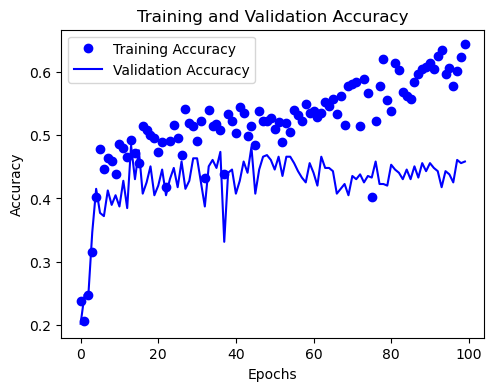

In [69]:
accuracy = history.history["accuracy"]
valaccuracymae = history.history["val_accuracy"]

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot( accuracy, "bo", label="Training Accuracy")
plt.plot(valaccuracymae, "b", label="Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.show()


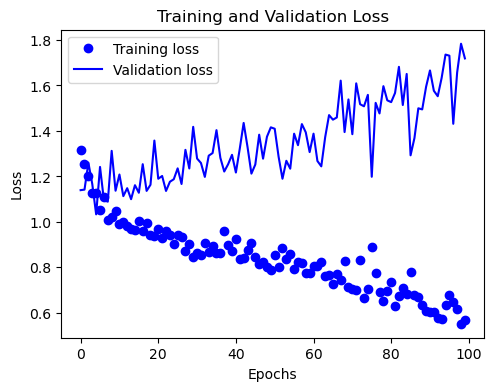

In [70]:
loss = history.history["loss"]
val_loss = history.history["val_loss"]

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot( loss, "bo", label="Training loss")
plt.plot(val_loss, "b", label="Validation loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()

# Predicciones, matrix de confusión e indicadores asociados

Predicciones

In [71]:
predicted_probabilities = model.predict(val_dataset)

40/40 [==============================] - 0s 2ms/step


In [72]:
predicted_probabilities

array([[1.8539693e-04, 9.8675275e-01, 1.3061918e-02],
       [8.5868591e-01, 1.4130598e-01, 8.0718592e-06],
       [1.6102441e-02, 7.2435939e-01, 2.5953817e-01],
       ...,
       [1.2879455e-01, 8.3211780e-01, 3.9087679e-02],
       [2.7654707e-03, 1.5651783e-01, 8.4071666e-01],
       [8.8754982e-01, 1.1240495e-01, 4.5212353e-05]], dtype=float32)

In [73]:
predicted_indices = np.argmax(predicted_probabilities, axis=-1)

In [74]:
predicted_indices

array([1, 0, 1, 2, 1, 2, 1, 1, 2, 1, 2, 2, 1, 1, 1, 1, 2, 1, 0, 1, 0, 2,
       0, 1, 0, 0, 2, 1, 2, 0, 0, 0, 1, 1, 1, 2, 1, 2, 2, 1, 1, 1, 1, 2,
       1, 0, 2, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 1, 2, 1, 2, 0, 2,
       2, 0, 2, 0, 0, 1, 2, 2, 2, 1, 1, 1, 2, 2, 1, 1, 1, 1, 2, 0, 2, 2,
       0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 2, 2, 1, 2, 1, 2, 1, 0, 1, 1, 1,
       1, 2, 1, 1, 0, 2, 2, 2, 2, 2, 2, 2, 0, 0, 2, 2, 1, 2, 1, 0, 1, 2,
       2, 2, 2, 1, 0, 1, 1, 1, 2, 0, 1, 2, 2, 1, 2, 2, 1, 1, 1, 0, 1, 2,
       0, 2, 1, 2, 1, 0, 1, 1, 1, 2, 2, 0, 2, 0, 0, 1, 2, 2, 2, 0, 1, 0,
       2, 2, 0, 2, 2, 1, 2, 1, 1, 1, 1, 2, 0, 0, 2, 2, 0, 1, 2, 1, 0, 0,
       1, 1, 1, 1, 1, 1, 0, 1, 2, 0, 0, 2, 2, 2, 1, 0, 1, 2, 2, 2, 2, 1,
       2, 1, 2, 2, 1, 2, 1, 2, 1, 2, 1, 1, 1, 2, 0, 1, 1, 1, 1, 2, 2, 1,
       2, 2, 1, 2, 2, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 2, 1, 2, 1, 2, 1,
       1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 2, 2, 1, 2, 0, 1, 0, 0, 2, 0, 1, 2,
       1, 2, 2, 2, 1, 1, 2, 1, 1, 1, 2, 1, 0, 2, 2,

Obtención de labels originales de validación

In [75]:
true_labels = []
for _, batch_labels in val_dataset:
    true_labels.extend(batch_labels.numpy())
true_labels = np.array(true_labels)


In [76]:
for samplesval, targetsval in val_dataset:
    print("samples shape:", samplesval.shape)
    print("targets shape:", targetsval.shape)
    break

samples shape: (10, 5, 65)
targets shape: (10,)


In [77]:
true_labels.shape

(395,)

In [78]:
predicted_indices.shape

(395,)

Revision de cantidad de predicciones true labels y predicciones

In [79]:
# Assuming targetcolumnarray is a numpy array or a list
unique_values, counts = np.unique(true_labels, return_counts=True)

# Print the unique values and their counts
for value, count in zip(unique_values, counts):
    print(f"{value}: {count}")

0.0: 94
1.0: 221
2.0: 80


In [80]:
# Assuming targetcolumnarray is a numpy array or a list
unique_values, counts = np.unique(predicted_indices, return_counts=True)

# Print the unique values and their counts
for value, count in zip(unique_values, counts):
    print(f"{value}: {count}")

0: 83
1: 171
2: 141


Creación de matriz de confusión

In [81]:
conf_mat = confusion_matrix(true_labels, predicted_indices)
conf_mat

array([[12, 51, 31],
       [56, 80, 85],
       [15, 40, 25]], dtype=int64)

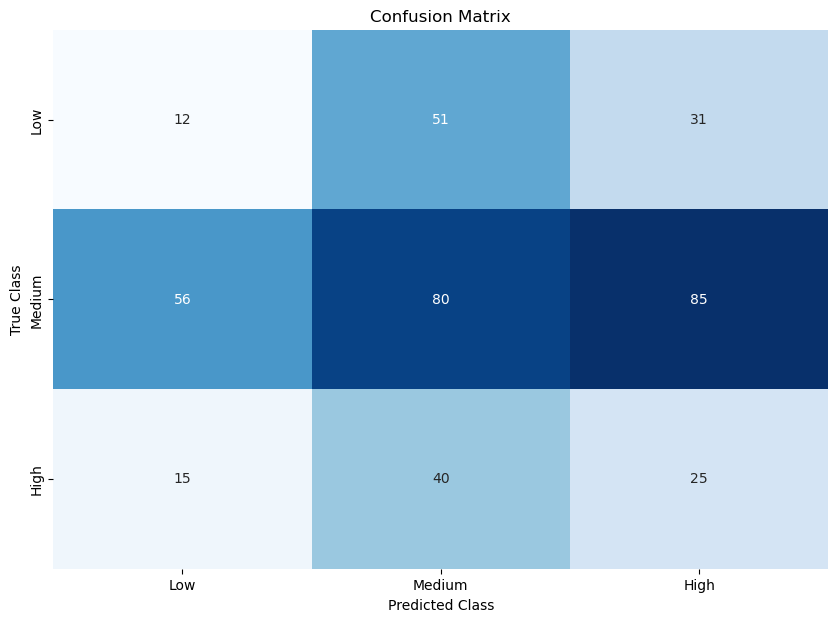

In [82]:
def plot_confusion_matrix(confusion_matrix, class_names):
    plt.figure(figsize=(10, 7))
    sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Class')
    plt.ylabel('True Class')
    plt.title('Confusion Matrix')
    plt.show()

class_names = [ 'Low', 'Medium', 'High']
plot_confusion_matrix(conf_mat, class_names)

In [83]:

# Create a DataFrame with true_labels and predicted_indices
result_df = pd.DataFrame({'True Labels': true_labels, 'Predicted Indices': predicted_indices})

# Create a pivot table with true_labels in rows, predicted_indices in columns, and the count as values
pivot_table = result_df.pivot_table(index='True Labels', columns='Predicted Indices', aggfunc=len, fill_value=0)

# Display the pivot table
print(pivot_table)


Predicted Indices   0   1   2
True Labels                  
0.0                12  51  31
1.0                56  80  85
2.0                15  40  25


Resultados finales

In [84]:
# Calculate the classification report
report = classification_report(true_labels, predicted_indices, target_names=class_names)

# Print the classification report
print(report)


              precision    recall  f1-score   support

         Low       0.14      0.13      0.14        94
      Medium       0.47      0.36      0.41       221
        High       0.18      0.31      0.23        80

    accuracy                           0.30       395
   macro avg       0.26      0.27      0.26       395
weighted avg       0.33      0.30      0.31       395

